In [7]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.tri as tri
from scipy import stats
from sklearn.metrics import confusion_matrix
from scipy.special import gamma as gamma_fun
import scipy.special as spec
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np


from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import EVIDENTIAL_DEFAULTS 
from deep_bayes.training import train_online
from deep_bayes.losses import log_loss
from deep_bayes.viz import plot_model_samples, plot_confusion_matrix
from deep_bayes.diagnostics import accuracy, expected_calibration_error, overconfidence

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
tf.enable_eager_execution()

In [10]:
%matplotlib inline

# Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [11]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [13]:
def model1_params_prior(**args):
    """
    Samples from the prior of the EV Model theta = (omega, phi, c)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = [
        np.random.uniform(low=0, high=1), 
        np.random.uniform(low=0, high=1),
        np.random.uniform(low=-2, high=2)
    ]
    return np.array(theta)


def model2_params_prior(**args):
    """
    Samples from the prior of the EV 2-parameters Model theta = (omega, phi)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = [
        np.random.uniform(low=0, high=1), 
        np.random.uniform(low=0, high=1)
    ]
    return np.array(theta)


def model3_params_prior(**args):
    """
    Samples from the prior of the EV with Decay Model theta = (omega, phi, c)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = [
        np.random.uniform(low=0, high=1), 
        np.random.uniform(low=0, high=1),
        np.random.uniform(low=-2, high=2)
    ]
    return np.array(theta)

def model4_params_prior(**args):
    """
    Samples from the prior of the PVL-Delta Model theta = (A, w, alpha, c)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = [
        np.random.uniform(low=0, high=1), 
        np.random.uniform(low=0, high=5),
        np.random.uniform(low=0, high=1),
        np.random.uniform(low=0, high=5)
    ]
    return np.array(theta)

## Generative models
<p>Defines how the data are generated, that is, $\boldsymbol{x}_{1:N} \sim p(\boldsymbol{x}|boldsymbol{\theta},\boldsymbol{m}).$

In [56]:
Wins = np.load('Wins.npy')
Losses = np.load('Losses.npy')


def stable_softmax(x):
    """Numerically stable softmax."""
    
    z = x - np.max(x)
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    softmax = numerator/denominator
    return softmax

def forward_model1(pars):
    # (Expectancy Valence Model)
    # omega: loss-aversion [0,1], 
    # phi: recency [0,1], 
    # c: consistency [-2,2]
    omega, phi, c = pars
    P = np.tile(1,4)/4
    choice = np.zeros(100, dtype=int)
    W = np.zeros(100)
    L = np.zeros(100)
    E = np.array([0,0,0,0])
    counter = [-1,-1,-1,-1]
    for t in range(100):
        choice[t] = np.random.choice([1,2,3,4],1,p=P)-1
        counter[choice[t]] += 1
        W[t] = Wins[counter[choice[t]],choice[t]]
        L[t] = Losses[t,choice[t]]
        u = (1 - omega)*W[t] + omega*L[t]
        E[choice[t]] = (1 - phi)*E[choice[t]] + phi*u
        theta = ((t+1)/10)**c
        P = stable_softmax(theta*E)
    return np.c_[W,L,choice+1]

def forward_model2(pars):
    # (Expectancy Valence Model 2-parameters)
    # omega: loss-aversion [0,1], 
    # phi: recency [0,1], 
    c = 0.5
    omega, phi = pars
    P = np.tile(1,4)/4
    choice = np.zeros(100, dtype=int)
    W = np.zeros(100)
    L = np.zeros(100)
    E = np.array([0,0,0,0])
    counter = [-1,-1,-1,-1]
    for t in range(100):
        choice[t] = np.random.choice([1,2,3,4],1,p=P)-1
        counter[choice[t]] += 1
        W[t] = Wins[counter[choice[t]],choice[t]]
        L[t] = Losses[t,choice[t]]
        u = (1 - omega)*W[t] + omega*L[t]
        E[choice[t]] = (1 - phi)*E[choice[t]] + phi*u
        theta = ((t+1)/10)**c
        P = stable_softmax(theta*E)
    return np.c_[W,L,choice+1]

def forward_model3(pars):
    # (Expectancy Valence with Decay Model)
    # omega: loss-aversion [0,1], 
    # phi: recency [0,1], 
    # c: consistency [-2,2]
    omega, phi, c = pars
    P = np.tile(1,4)/4
    choice = np.zeros(100, dtype=int)
    W = np.zeros(100)
    L = np.zeros(100)
    E = np.array([0,0,0,0])
    counter = [-1,-1,-1,-1]
    for t in range(100):
        choice[t] = np.random.choice([1,2,3,4],1,p=P)-1
        counter[choice[t]] += 1
        W[t] = Wins[counter[choice[t]],choice[t]]
        L[t] = Losses[t,choice[t]]
        u = (1 - omega)*W[t] + omega*L[t]
        E = phi*E
        E[choice[t]] = E[choice[t]] + u
        theta = ((t+1)/10)**c
        P = stable_softmax(theta*E)
    return np.c_[W,L,choice+1]

def forward_model4(pars):
    # (PVL-delta Model)
    # A: shape [0,1], 
    # w: loss-aversion [0,5], 
    # alpha: updating [0,1], 
    # c: consistency [0,5]
    A, w, alpha, c = pars
    P = np.tile(1,4)/4
    choice = np.zeros(100, dtype=int)
    W = np.zeros(100)
    L = np.zeros(100)
    E = np.array([0,0,0,0])
    counter = [-1,-1,-1,-1]
    for t in range(100):
        choice[t] = np.random.choice([1,2,3,4],1,p=P)-1
        counter[choice[t]] += 1
        W[t] = Wins[counter[choice[t]],choice[t]]
        L[t] = Losses[t,choice[t]]
        Net = W[t] - np.abs(L[t])
        u = (Net >= 0)*(np.abs(Net)**A) + (Net < 0)*(-w*np.abs(Net)**A)
        E[choice[t]] = E[choice[t]] + alpha*(u - E[choice[t]])  
        theta = 3**c - 1
        P = stable_softmax(theta*E)
    return np.c_[W,L,choice+1]

## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [57]:
def data_generator(batch_size, model_prior, param_priors, forward_models, alpha_smooth=None,
                   n_obs=None, n_obs_min=100, n_obs_max=500, n_to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------

    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    alpha_smooth   : float or None -- the label smoothing hyperparameter
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------

    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """

    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)

    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)


    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:

        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()

        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m) 

        # Store data and params
        x.append(x_m)
        theta.append(theta_m)

    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)

    # Stote x into a tensor
    x = np.array(x)

    # Apply label smoothing, if specified
    if alpha_smooth is not None:
        m = m * (1 - alpha_smooth) + alpha_smooth / n_models

    # Convert to tensor, if specified 
    if to_tensor:# Sample N, if not specified
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'theta': theta, 'x': x}

# Training hyperparameters

In [58]:
#--- Training hyperparameters ---#
ckpt_file = "igt_model_selection"
batch_size = 64
epochs = 50
iterations_per_epoch = 1000
n_obs = 50
n_test = 300


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.001
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#
model_names = ['M1', 'M2', 'M3', 'M4']
param_priors = [model1_params_prior, model2_params_prior, model3_params_prior]
forward_models = [forward_model1, forward_model2, forward_model3]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs)

## Create test data

In [59]:
%%time
test_data = data_gen(n_test)

FloatingPointError: underflow encountered in exp

## Create model

In [ ]:
model = DeepEvidentialModel(EVIDENTIAL_HH)

## Manage checkpoints

In [ ]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


# Train network

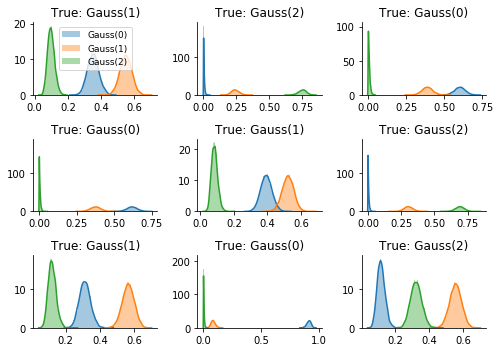

In [ ]:
for ep in range(1, 1+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=partial(log_loss, lambd=0.0), 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence')
        
        
        # Plot stuff
        m_pred = model(test_data['x'])['m_probs']
        plot_confusion_matrix(m_pred.numpy().argmax(axis=1), test_data['m'], model_names, figsize=(8,4),normalize=True)
        print(accuracy(test_data['m'], m_pred))
                

        # Store checkpoint
        manager.save()

# Validate evidential network

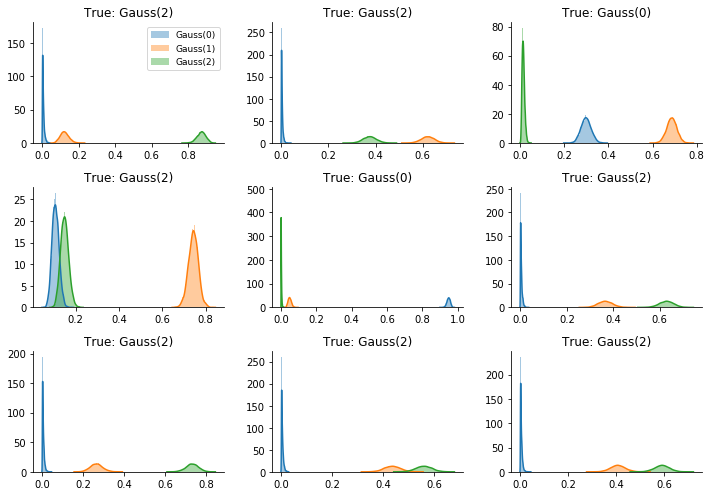

In [178]:
plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:9], 
                       m_test=test_data['m'][:9], 
                       model_names=model_names,
                       figsize=(10, 7))

In [ ]:
plot_confusion_matrix(model, test_data['x'], test_data['m'], model_names, normalize=True)